# 06_03_neu: Data Augmentation Practice (CPU)

## Einführung
Augmentation als Gegenmittel zu Overfitting: Vergleich von Keras-Preprocessing-Layern mit optionalem Albumentations-Stack, trainiert auf einem kleinen CIFAR-Subset mit/ohne Augmentation.

**Lernziele**
- Overfitting auf kleinem Datensatz erkennen
- Keras-Augmentationspipeline konfigurieren und im `tf.data`-Stream nutzen
- (Optional) Albumentations als Referenz ausprobieren
- Trainings- und Test-Accuracy mit/ohne Augmentation vergleichen
- Laufzeit steuern: Anzahl Samples, Epochen und Batchgröße anpassen

In [1]:
# Setup & Data (tiny subset)
import os, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42); random.seed(42); tf.random.set_seed(42)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
keep = 3000
x_train, y_train = x_train[:keep], y_train[:keep]
x_test, y_test = x_test[:800], y_test[:800]
class_names = ["airplane","auto","bird","cat","deer","dog","frog","horse","ship","truck"]

x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0

print("Train", x_train.shape, "Test", x_test.shape)


Train (3000, 32, 32, 3) Test (800, 32, 32, 3)


/var/folders/qz/yzbl_3nj31sfz8p5s1wydw4c0000gn/T/ipykernel_23053/3601755166.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(class_names[int(label)])


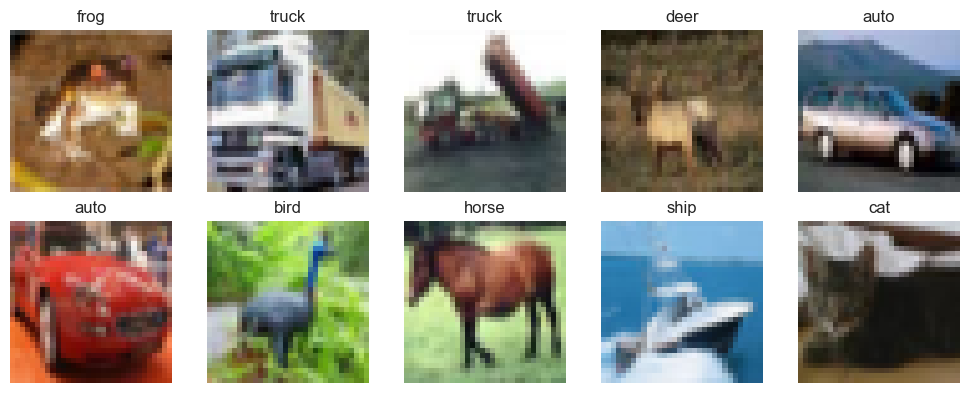

In [2]:
# Visual sanity check
fig, axes = plt.subplots(2,5, figsize=(10,4))
for ax, img, label in zip(axes.flat, x_train[:10], y_train[:10]):
    ax.imshow(img)
    ax.set_title(class_names[int(label)])
    ax.axis("off")
plt.tight_layout(); plt.show()


In [3]:
# Keras preprocessing pipeline
augment_layers = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Albumentations alternative (optional)
try:
    import albumentations as A
    alb_aug = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(0.1,0.1,p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    ])
except ImportError:
    alb_aug = None
    print("Albumentations nicht installiert - Keras-Only Demo.")


Albumentations nicht installiert - Keras-Only Demo.


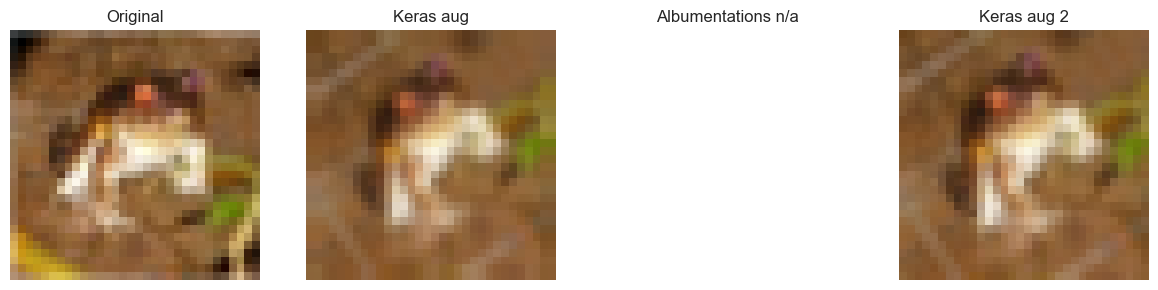

In [4]:
# Compare augmentations
sample = x_train[0]

fig, axes = plt.subplots(1,4, figsize=(12,3))
axes[0].imshow(sample); axes[0].set_title("Original"); axes[0].axis("off")

keras_aug = augment_layers(tf.convert_to_tensor(sample[None,:,:,:])).numpy()[0]
axes[1].imshow(keras_aug); axes[1].set_title("Keras aug"); axes[1].axis("off")

if alb_aug:
    alb_img = alb_aug(image=(sample*255).astype(np.uint8))['image']
    axes[2].imshow(alb_img); axes[2].set_title("Albumentations"); axes[2].axis("off")
else:
    axes[2].axis("off"); axes[2].set_title("Albumentations n/a")

# stronger Keras example
keras_aug2 = augment_layers(tf.convert_to_tensor(sample[None,:,:,:])).numpy()[0]
axes[3].imshow(keras_aug2); axes[3].set_title("Keras aug 2")
axes[3].axis("off")

plt.tight_layout(); plt.show()


In [5]:
# Mini-CNN helper

def make_model():
    return keras.Sequential([
        layers.Input(shape=(32,32,3)),
        layers.Conv2D(32,3,activation='relu',padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(64,3,activation='relu',padding='same'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64,activation='relu'),
        layers.Dense(10,activation='softmax'),
    ])


In [6]:
# Train baseline (no aug)
baseline = make_model()
baseline.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
h_baseline = baseline.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=3,
    batch_size=128,
    verbose=2,
)

# Train with Keras aug pipeline
augmented = make_model()
augmented.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

data_aug = augment_layers

aug_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(keep, seed=42)
    .batch(128)
    .map(lambda x,y: (data_aug(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

h_aug = augmented.fit(
    aug_ds,
    validation_data=(x_test, y_test),
    epochs=3,
    verbose=2,
)



Epoch 1/3


22/22 - 1s - 47ms/step - accuracy: 0.1189 - loss: 2.2871 - val_accuracy: 0.1633 - val_loss: 2.2582


Epoch 2/3


22/22 - 0s - 20ms/step - accuracy: 0.1526 - loss: 2.2245 - val_accuracy: 0.1967 - val_loss: 2.1887


Epoch 3/3


22/22 - 0s - 20ms/step - accuracy: 0.1789 - loss: 2.1646 - val_accuracy: 0.2333 - val_loss: 2.1286


Epoch 1/3


24/24 - 1s - 44ms/step - accuracy: 0.1180 - loss: 2.2973 - val_accuracy: 0.1600 - val_loss: 2.2814


Epoch 2/3


24/24 - 1s - 25ms/step - accuracy: 0.1647 - loss: 2.2583 - val_accuracy: 0.2013 - val_loss: 2.2066


Epoch 3/3


24/24 - 1s - 26ms/step - accuracy: 0.1837 - loss: 2.1847 - val_accuracy: 0.2225 - val_loss: 2.1360


In [7]:
# Eval comparison
bl_acc = baseline.evaluate(x_test, y_test, verbose=0)[1]
aug_acc = augmented.evaluate(x_test, y_test, verbose=0)[1]
print(f"Baseline acc: {bl_acc:.3f} vs Aug acc: {aug_acc:.3f}")


Baseline acc: 0.211 vs Aug acc: 0.222


## Tipps
- Für noch schnellere Läufe: keep=1500, epochs=2.
- Albumentations nur optional; Kernpipeline ist Keras-preprocessing.
- Augmentation im tf.data-Stream belassen, um RAM zu sparen.